In [200]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [201]:
df_transactions = pd.read_json('../data/transactions.json', lines=True)
df_users = pd.read_csv('../data/users.csv')
df_merchants = pd.read_csv('../data/merchants.csv')

## Merge all tables

In [202]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')
df_merged = df_merged.rename(columns={'country_x': 'country_user', 'country_y': 'country_merchant'})
df = df_merged

In [203]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,country_user,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,...,Sweden,2022-08-10,0.426675,travel,France,0.581711,3,74.97,23,1
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,...,France,2024-05-22,0.729627,electronics,Germany,0.568933,2,56.92,23,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,...,Italy,2021-05-18,0.393848,gaming,Denmark,0.608070,5,98.93,75,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,...,Portugal,2021-09-05,0.393405,electronics,Portugal,0.592656,4,21.60,82,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,...,Austria,2023-06-01,0.524168,gaming,Spain,0.450223,4,60.61,82,0


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   location                        500000 non-null  object        
 9   payment_method                  500000 non-null  object        
 10  is_international                500000 non-null  int64  

## Feature engineering
Created new columns:

(instead of `location`)
- `latitude`
- `longitude`

In [205]:
# Extract latitude and longitude into separate columns
df['latitude'] = df['location'].apply(lambda x: x['lat'])
df['longitude'] = df['location'].apply(lambda x: x['long'])
df.drop(columns=['location'], inplace=True)

- `hour`
- `day_of_week`
- `is_weekend`
- `month`

In [206]:
# --------- Temporal data feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Monday
df['is_weekend'] = df['day_of_week'] >= 5
df['is_weekend'] = df['is_weekend'].astype(int)

df['month'] = df['timestamp'].dt.month

- `time_since_last_user_txn`
- `time_since_last_merchant_txn`
- `time_since_last_user_merchant`

In [207]:
# Time Since Last Transaction: User-level
df = df.sort_values(['user_id', 'timestamp'])
df['time_since_last_user_txn'] = (
    df.groupby('user_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

# Time Since Last Transaction: Merchant-level
df = df.sort_values(['merchant_id', 'timestamp'])
df['time_since_last_merchant_txn'] = (
    df.groupby('merchant_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

df['last_user_merchant_ts'] = df.groupby(['user_id', 'merchant_id'])['timestamp'].shift(1)
df['time_since_last_user_merchant'] = (df['timestamp'] - df['last_user_merchant_ts']).dt.total_seconds()

df.drop(columns=['last_user_merchant_ts'], inplace=True)

- `prev_latitude`
- `prev_longitude`
- `distance_from_last_txn_km`
-  `velocity_kmph`

In [208]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # distance in km

In [209]:
# --------- Geo-data feature engineering
df.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Shift lat/lon to get last user's lat/lon
df['prev_latitude'] = df.groupby('user_id')['latitude'].shift(1)
df['prev_longitude'] = df.groupby('user_id')['longitude'].shift(1)

df['distance_from_last_txn_km'] = df.apply(
    lambda row: haversine_distance(row['prev_latitude'], row['prev_longitude'],
                                   row['latitude'], row['longitude']),
    axis=1
)

df['velocity_kmph'] = df.apply(
    lambda row: (
        row['distance_from_last_txn_km'] / (row['time_since_last_user_txn'] / 3600)
        if row['time_since_last_user_txn'] > 0 else np.nan
    ),
    axis=1
)

- `merchant_fraud_rate`

In [210]:
# --------- Merchant data feature engineering
merchant_fraud_rates = df.groupby('merchant_id')['is_fraud'].mean()
df = df.merge(merchant_fraud_rates.rename('merchant_fraud_rate'), on='merchant_id')

- `rolling_fraud_count`
- `rolling_txn_count`
- `rolling_fraud_rate`

In [211]:
parameters = {
    "window" : '1h',
    "zscore_threshold" : 3
}

In [212]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['country_merchant', 'timestamp'])
df.set_index('timestamp', inplace=True)

# 8-hour rolling stats

df['rolling_fraud_count'] = (
    df
    .groupby('country_merchant')['is_fraud']
    .rolling(window=parameters['window'])
    .sum()
    .reset_index(level=0, drop=True)
)

df['rolling_txn_count'] = (
    df
    .groupby('country_merchant')['is_fraud']
    .rolling(window=parameters['window'])
    .count()
    .reset_index(level=0, drop=True)
)

# df['rolling_fraud_rate'] = (
#     df['rolling_fraud_count'] / df['rolling_txn_count']
# ).fillna(0)

df = df.reset_index()

- `fraud_rate_change`
- `zscore_fraud_rate`
- `rolling_fraud_rate`

In [213]:
# df['fraud_rate_change'] = (
#     df.groupby('country_merchant')['rolling_fraud_rate'].diff()
# )

# # Z-score of fraud rate per country_merchant
# df['zscore_fraud_rate'] = (
#     df.groupby('country_merchant')['rolling_fraud_rate']
#     .transform(lambda x: zscore(x.fillna(0)))
# )

# # # Attack starts: rate jumps or statistical spike
# # df_merged['fraud_attack_start_flag'] = (
# #     # (df_merged['fraud_rate_change'] > 0.15) |
# #     (df_merged['zscore_fraud_rate'] > parameters['zscore_threshold'])
# # )

In [214]:
df.head()

,timestamp,transaction_id,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,time_since_last_user_txn,time_since_last_merchant_txn,time_since_last_user_merchant,prev_latitude,prev_longitude,distance_from_last_txn_km,velocity_kmph,merchant_fraud_rate,rolling_fraud_count,rolling_txn_count
0,2022-01-01 01:01:00,TX346973,U09294,M0533,14.00,online,EUR,Android,mobile_payment,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049462,0.0,1.0
1,2022-01-01 01:21:00,TX107936,U06771,M0398,6.83,mobile,EUR,Web,debit_card,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093220,0.0,2.0
2,2022-01-01 01:31:00,TX014454,U11113,M0157,62.53,online,EUR,Web,credit_card,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089820,0.0,3.0
3,2022-01-01 02:01:00,TX162234,U15392,M0706,3.60,in-store,EUR,iOS,bank_transfer,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057026,0.0,3.0
4,2022-01-01 02:13:00,TX437234,U09528,M0740,30.70,mobile,EUR,iOS,debit_card,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072314,0.0,4.0


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   timestamp                       500000 non-null  datetime64[ns]
 1   transaction_id                  500000 non-null  object        
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   payment_method                  500000 non-null  object        
 9   is_international                500000 non-null  int64         
 10  session_length_seconds          500000 non-null  int64  

---------------------------------------------------------------------------------------
# MODEL FOR FEATURE SELECTION: XGBOOST

Drop columns

In [216]:
cols_to_drop = ['transaction_id','user_id','timestamp','merchant_id','signup_date']
df = df.drop(columns=cols_to_drop)

In [217]:
df.to_csv("../data.csv")

In [218]:
from sklearn.model_selection import train_test_split

X = df.drop('is_fraud',axis=1)
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [219]:
categorical_cols = [
    'channel', 'currency', 'device', 'payment_method', 'category',
    'country_user', 'country_merchant', 'sex', 'education', 'primary_source_of_income'
]

binary_cols = [
    'is_international', 'is_first_time_merchant', 'has_fraud_history'
]

numerical_cols = [
    'amount', 'session_length_seconds', 'age', 'risk_score', 'trust_score',
    'number_of_alerts_last_6_months', 'avg_transaction_amount',
    'account_age_months', 'sum_of_monthly_expenses', 'sum_of_monthly_installments'
]

In [220]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [221]:
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [222]:
X_train.head()

,amount,channel,currency,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,...,time_since_last_user_txn,time_since_last_merchant_txn,time_since_last_user_merchant,prev_latitude,prev_longitude,distance_from_last_txn_km,velocity_kmph,merchant_fraud_rate,rolling_fraud_count,rolling_txn_count
212778,2.87,2,0,1,0,1,1029,0,24,0,...,1250700.0,229080.0,NaN,50.899130,28.243111,2652.940314,7.636192,0.048828,1.0,3.0
376271,91.09,1,0,2,0,1,322,0,37,2,...,75600.0,51420.0,37340640.0,61.350220,17.430512,2871.929275,136.758537,0.065844,0.0,2.0
170920,67.01,0,0,0,2,1,270,0,30,1,...,791760.0,372300.0,NaN,47.089412,20.229138,2311.514883,10.510071,0.079570,0.0,3.0
361474,12.42,2,0,2,2,1,942,1,24,2,...,335640.0,17820.0,13210620.0,62.054440,2.139929,2714.554974,29.115713,0.112205,0.0,2.0
179453,22.28,1,0,2,1,1,627,0,38,1,...,267480.0,295140.0,NaN,50.891173,-3.914048,998.394112,13.437337,0.048356,0.0,1.0


In [223]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350000 entries, 212778 to 397958
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   amount                          350000 non-null  float64
 1   channel                         350000 non-null  int64  
 2   currency                        350000 non-null  int64  
 3   device                          350000 non-null  int64  
 4   payment_method                  350000 non-null  int64  
 5   is_international                350000 non-null  int64  
 6   session_length_seconds          350000 non-null  int64  
 7   is_first_time_merchant          350000 non-null  int64  
 8   age                             350000 non-null  int64  
 9   sex                             350000 non-null  int64  
 10  education                       350000 non-null  int64  
 11  primary_source_of_income        350000 non-null  int64  
 12  sum_of_monthly_i

In [224]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]  


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',        
    'eta': 0.1,                      
    'max_depth': 6,                   
    'subsample': 0.8,                 
    'colsample_bytree': 0.8,         
    'scale_pos_weight': scale_pos_weight  
}

num_round = 100  
bst = xgb.train(params, dtrain, num_round)


y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions


print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.85554

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    137277
           1       0.37      1.00      0.54     12723

    accuracy                           0.86    150000
   macro avg       0.68      0.92      0.73    150000
weighted avg       0.95      0.86      0.88    150000



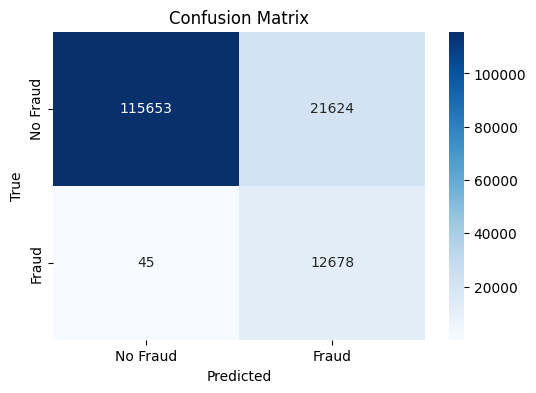

In [225]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Feature Importance (using weight):
{'amount': 111.0, 'channel': 16.0, 'device': 9.0, 'payment_method': 10.0, 'is_international': 51.0, 'session_length_seconds': 91.0, 'is_first_time_merchant': 6.0, 'age': 61.0, 'sex': 11.0, 'education': 20.0, 'primary_source_of_income': 31.0, 'sum_of_monthly_installments': 84.0, 'sum_of_monthly_expenses': 87.0, 'country_user': 46.0, 'risk_score': 195.0, 'category': 12.0, 'country_merchant': 41.0, 'trust_score': 77.0, 'number_of_alerts_last_6_months': 26.0, 'avg_transaction_amount': 65.0, 'account_age_months': 80.0, 'has_fraud_history': 20.0, 'latitude': 88.0, 'longitude': 104.0, 'hour': 44.0, 'day_of_week': 20.0, 'month': 32.0, 'time_since_last_user_txn': 94.0, 'time_since_last_merchant_txn': 91.0, 'time_since_last_user_merchant': 51.0, 'prev_latitude': 100.0, 'prev_longitude': 117.0, 'distance_from_last_txn_km': 97.0, 'velocity_kmph': 73.0, 'merchant_fraud_rate': 244.0, 'rolling_fraud_count': 204.0, 'rolling_txn_count': 280.0}


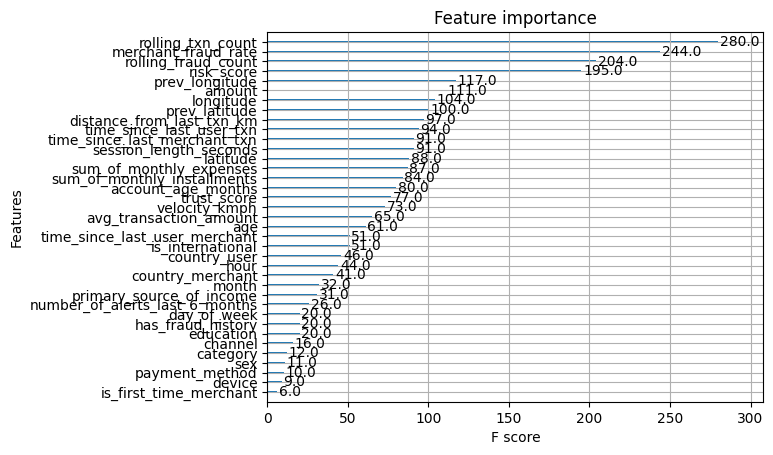

In [226]:
importance = bst.get_score(importance_type='weight')  


print("Feature Importance (using weight):")
print(importance)


xgb.plot_importance(bst, importance_type='weight') 
plt.show()

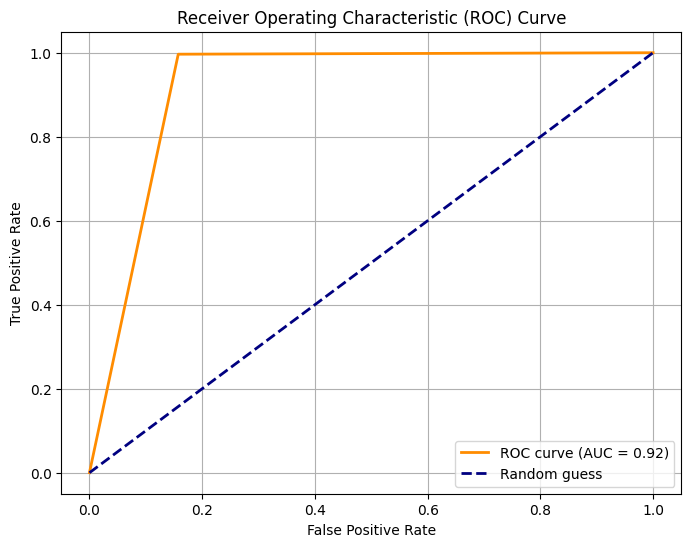

AUC: 0.9194710867402405


In [227]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')